In [1]:
from random import shuffle, randint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, LineString, mapping, shape
from descartes import PolygonPatch
import random
import fiona
import numpy as np
import csv
from fiona import collection

import geopandas as gpd
from geopandas.tools import sjoin # rtree index in-build, used with inner, intersection
import pandas as pd

from collections import defaultdict


In [ ]:
def csv_dict_reader(file_obj):

    """

    Read a CSV file using csv.DictReader

    """

    reader = csv.DictReader(file_obj, delimiter=',')
    data_list=[]
    for line in reader:
        data_list.append(line)
        
    return data_list

Adding crime numbers to the shapefiles

In [ ]:
with open("crime/pp_murder_2015.csv") as f_obj:
        pp_data = csv_dict_reader(f_obj)
        
# rearrange the dict so the districts are directly the keys
pp_data_d = {}
pp_data_prov = {}

for i in pp_data:
    pp_data_d[i['PoliceStation'].lower()] = int(i['Incidents']) 
    pp_data_prov[i['PoliceStation'].lower()] = i['Province'] 


In [ ]:
# police precincts
polSHP  = 'crime/pol_prec.shp'


# aggregate values from array x to a newly created key in d
def aggregate(data, key1, xdata, key2): 
    i = 1 # check of the num of crimes is present
    try:
            temp = xdata[data[key2]]
    except:
            temp = 0
            
    data[key1] = temp 
    return i

with collection(polSHP, 'r') as input:
    sink_schema = input.schema.copy()
    sink_schema['properties']['murd_cnt'] = 'int'
    sink_schema['properties']['province'] = 'str:25'

    # not specifying the .shp creates a dir with all files in it
    with collection("crime/GIS-analyses/polPrec_murd2015_prov", "w", "ESRI Shapefile", sink_schema) as sink:
        
        for pt in input:
                pt_tosave = pt
                # will be adding a property
                pt_prop = pt['properties']       
                pt_prop['compnt_nm'] = pt_prop['compnt_nm'].lower() # change to lower case to be able to compare
        
                check_exists = aggregate(pt_prop, 'murd_cnt', pp_data_d, 'compnt_nm') # modifies d on the spot
                check_exists = aggregate(pt_prop, 'province', pp_data_prov, 'compnt_nm') # modifies d on the spot

                pt_tosave['properties'].update(pt_prop)
                
                sink.write(pt_tosave)


In [50]:
geo_sal.head()

,DC_MDB_C,DC_MN_C,DC_MN_C_st,DC_NAME,MN_CODE,MN_CODE_st,MN_MDB_C,MN_NAME,MP_CODE,MP_CODE_st,...,PR_MDB_C,PR_NAME,SAL_CODE,SAL_CODE_s,SP_CODE,SP_CODE_st,SP_NAME,Shape_Area,Shape_Leng,geometry
0,DC1,101,101,West Coast,160,160,WC011,Matzikama,160001,160001,...,WC,Western Cape,1600090,1600090,160001001,160001001,Kliprand SP,0.000090,0.059396,POLYGON ((18.68988157500007 -30.60189670299991...
1,DC1,101,101,West Coast,160,160,WC011,Matzikama,160002,160002,...,WC,Western Cape,1600001,1600001,160002001,160002001,Matzikama NU,0.003276,0.255637,POLYGON ((18.35723010300006 -31.57914551399995...
2,DC1,101,101,West Coast,160,160,WC011,Matzikama,160002,160002,...,WC,Western Cape,1600002,1600002,160002001,160002001,Matzikama NU,0.001346,0.253267,POLYGON ((18.46169438500004 -31.64855819899992...
3,DC1,101,101,West Coast,160,160,WC011,Matzikama,160002,160002,...,WC,Western Cape,1600003,1600003,160002001,160002001,Matzikama NU,0.005201,0.318789,POLYGON ((18.06327575100005 -30.91043594799993...
4,DC1,101,101,West Coast,160,160,WC011,Matzikama,160002,160002,...,WC,Western Cape,1600005,1600005,160002001,160002001,Matzikama NU,0.946345,7.464325,POLYGON ((18.77038002100005 -30.58613014199994...


In [48]:
polSHP  = 'crime/pol_prec.shp'

polSHP.format_map

<function str.format_map>

Adding population data to the SAL shapefiles

In [ ]:
salSHP = 'crime/SAL_SA_2013.shp'

with open("crime/sal_processed_head.csv") as f_obj:

      sal_data = csv_dict_reader(f_obj)

sal_data_d = {}

# put it in a dictionary
for i in sal_data:
    sal_data_d[int(i["district"])]=int(i["count"]) 



# aggregate values from array x to a newly created key in d- it enforces int on the key
def aggregate_int(d, key1, x, key2): 
    i = 1 # check of the num of crimes is present
    try:
            temp = x[int(d[key2])]
    except:
            temp = 0
            
    d[key1] = temp #x[d[key2]]
    return i

with collection(salSHP, 'r') as input:
    sink_schema_sal = input.schema.copy()
    sink_schema_sal['properties']['PPL_CNT'] = 'int'
    
    # not specifying the .shp creates a dir with all files in it
    with collection("crime/GIS-analyses/sal_population", "w", "ESRI Shapefile", sink_schema_sal) as sink:
        
        for pt in input:
            d = pt['properties']
            # this bit is for city of Cape Town
            #if (d['MN_NAME'] == 'City of Cape Town'): # we restrict to the City of CT
            f = pt       
        
            check_exists = aggregate_int(d, 'PPL_CNT', sal_data_d, 'SAL_CODE') # modifies d on the spot
                
                #sal_shp_all_data[i]['PPL_CNT'] = sal_data_d[int(sal_shp_all_data[i]['SAL_CODE'])]

            f['properties'].update(d)
                
            sink.write(f)

In [2]:
import geopandas as gpd
from geopandas.tools import sjoin # rtree index in-build, used with inner, intersection

def find_intersections(o):
    
    from collections import defaultdict

    paired_ind = [o.polPrecincts_index, o.sal_index]

    d_over_ind = defaultdict(list)

    # creating a dictionary that has prescints as keys and associated small areas as values
    for i in range(len(paired_ind[0].values)):
        if not paired_ind[0].values[i]==paired_ind[1].values[i]: # it shows itself as intersection
            d_over_ind[paired_ind[0].values[i]].append(paired_ind[1].values[i])

    # get rid of the pol precincts with no small areas associated to them- not the most efficient way
    d_temp = {}
    for l in d_over_ind:
        if len(d_over_ind[l]):
            d_temp[l] = d_over_ind[l]

    return d_temp
    
    
def calculate_join_indices(g1, g2):

        #pol_extSHP = 'crime/GIS-analyses/pol_sub_external/pol_sub_external.shp'
        # A: region of the police data with criminal record
        # C: small area with population data
        # we look for all small areas intersecting a given C_i, calculate the fraction of inclusion, scale the
        # population accordingly: area(A_j, where A_j crosses C_i)/area(A_j)* popul(A_j)

        g1_reind = g1.reset_index().rename(columns={'index':'polPrecincts_index'})
        g2_reind = g2.reset_index().rename(columns={'index':'sal_index'})

        # the actual indexing:
        out = sjoin(g1_reind, g2_reind, how ="inner", op = "intersects")
        out.drop('index_right', axis=1, inplace=True) # there is a double index fo smal areas, so we drop one
        #out_sorted = out.sort(columns='polPrecincts_index', ascending=True) # guess sorting is not necessary, cause we are
        # using doctionaries at later stages
        #dict_over_ind = find_intersections(out_sorted)

        # output retains only 1 area (left or right join), and gives no intersection area.
        # so we create an array with paired indices: police precincts with associated small areas
        # we use it in a loop in a function below
        dict_over_ind = find_intersections(out) 
        
        return dict_over_ind, g1_reind, g2_reind
    
def calculate_join(dict_over_ind, g1_reind, g2_reind, out_name):
        area_total = 0
        data1 = []

        # note to self: make sure to import shapely Polygon
        for index1, crim in g1_reind.iterrows():
            try:
                index1 = crim.polPrecincts_index
                sals_found = dict_over_ind[index1]

                for sal in range(len(sals_found)):
                    pom = g2_reind[g2_reind.sal_index == sals_found[sal]]['geometry']        

                    #if pom.intersects(crim['geometry']).values[0]:
                    area_int = pom.intersection(crim['geometry']).area.values[0]
                    if area_int>0:
                        area_total += area_int 
                        area_crim = crim['geometry'].area

                        area_popu = pom.values[0].area

                        popu_count = g2_reind[g2_reind.sal_index == sals_found[sal]]['PPL_CNT'].values[0]
                        murd_count = crim['murd_cnt']
                        pol_province = crim['province']
                        popu_frac = (area_int / area_popu) * popu_count# fraction of the pop area contained inside the crim
                        #print(popu_frac)
                        extra_info = g2_reind[g2_reind.sal_index == sals_found[sal]].filter(regex=("NAME"))
                        extra_info_col_names = ['DC_NAME','MN_NAME','MP_NAME','PR_NAME','SP_NAME']
                        data1.append({'geometry': pom.intersection(crim['geometry']).values[0], 'id1': index1,\
                                      'id2': sals_found[sal] ,'area_crim': area_crim,'area_pop': area_popu,\
                                  'area_inter': area_int, 'popu_frac' : popu_frac, 'popu_count': popu_count,\
                                  'murd_cnt': murd_count,'province': pol_province,'DC_NAME': extra_info.DC_NAME.values[0],\
                                  'MN_NAME': extra_info.MN_NAME.values[0], 'MP_NAME': extra_info.MP_NAME.values[0],\
                                  'PR_NAME': extra_info.PR_NAME.values[0],'SP_NAME': extra_info.SP_NAME.values[0]} )
            except:
                pass
df_t = gpd.GeoDataFrame(data1,columns=['geometry', 'id1','id2','area_crim', 'area_pop','area_inter', 'popu_frac',\
                                       'popu_count', 'murd_cnt','province','DC_NAME','MN_NAME','MP_NAME','PR_NAME','SP_NAME'])
df_t.to_file(out_name)
return df_t, area_total, data1

Main functions to find intersection:

In [3]:
salSHP_full = 'crime/GIS-analyses/sal_population/sal_population.shp'
polSHP_full = 'crime/GIS-analyses/polPrec_murd2015_prov/polPrec_murd2015_prov.shp'

geo_pol = gpd.GeoDataFrame.from_file(polSHP_full)
geo_sal = gpd.GeoDataFrame.from_file(salSHP_full)



dict_int, geo_pol_reind, geo_sal_reind = calculate_join_indices(geo_pol,geo_sal)
out_name ='crime/GIS-analyses/pooled_data/intersection_int.shp'
df, sum_area, data = calculate_join(dict_int, geo_pol_reind, geo_sal_reind, out_name)


1
2


In [37]:
geo_pol.head()


,compnt_nm,create_dt,geometry,murd_cnt,province,version
0,botshabelo,20140207,POLYGON ((26.77137012000003 -29.21402997000003...,25,Free State,1.1.0
1,kubusiedrift,20140207,POLYGON ((27.72830016000002 -32.53050000000003...,0,0,1.1.0
2,stutterheim,20140207,POLYGON ((27.50200992000002 -32.44217004000003...,18,Eastern Cape,1.1.0
3,motherwell,20140207,POLYGON ((25.61061384000002 -33.81771897000003...,44,Eastern Cape,1.1.0
4,kwadwesi,20140207,POLYGON ((25.52826996000002 -33.82934004000003...,27,Eastern Cape,1.1.0


check for self-intersections

In [ ]:
geo_sal_WC = geo_sal[geo_sal.PR_NAME=='Western Cape']
geo_sal_reind = geo_sal_WC.set_index(['SAL_CODE','SP_NAME'])
sal_wc_union = geo_sal_reind.unary_union

find pol precincts within WC boundary

In [40]:
za_province = gpd.read_file('crime/GIS-analyses/za-provinces.topojson',driver='GeoJSON')#.set_index('id')
za_province.crs={'init': '27700'}

#wc=za_province[za_province.index=='8']
#wc.reset_index()
wc_boundary = za_province.ix[8].geometry
#pp_WC = geo_pol[geo_pol.geometry.within(wc_boundary)]
pp_WC_in = geo_pol[geo_pol.geometry.intersects(wc_boundary)]

In [41]:
pp_WC_overlaps = pp_WC_in[pp_WC_in.province!="Western Cape"]
pp_WC_pol_annot = pp_WC_in[pp_WC_in.province=="Western Cape"]

In [42]:
#pp_test = pp_WC_in[pp_WC_in['compnt_nm'].isin(['atlantis','philadelphia','kraaifontein','brackenfell','kuilsriver','kleinvleveerste river','macassar','somerset west','fish hoek'])]
#pp_test = pp_WC_in[pp_WC_in['compnt_nm'].isin(['beaufort west','doring bay','murraysburg', 'strandfontein','nuwerus','lutzville'])]

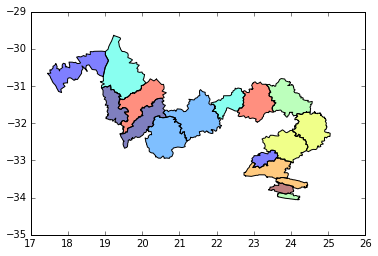

In [44]:
%matplotlib inline
pp_WC_overlaps.plot()

In [ ]:
sal_wc_union_bound = sal_WC_in.unary_union

In [ ]:
#dict_int_wc_in, geo_pol_reind, sal_WC_in_reind = calculate_join_indices(geo_pol,sal_WC_in)
#out_name ='crime/GIS-analyses/pooled_data/intersection_int_wc_in.shp'
#df, sum_area, data = calculate_join(dict_int_wc_in, geo_pol_reind, sal_WC_in_reind , out_name)


In [11]:
# add population data per police percinct to the main table
temp = df_t.groupby(by=['id1'])['popu_frac'].sum().reset_index()

data_with_pop = pd.merge(df_t, temp, on='id1', how='outer')\
        .rename(columns={'popu_frac_y':'popu_frac_per_police_precinct', 'popu_frac_x':'popu_intersection'})

# finally, update the murder rate per SAL : id2 is sal's id    

data_with_pop['murd_est_per_int'] = data_with_pop['popu_intersection']/data_with_pop['popu_frac_per_police_precinct']\
           * data_with_pop['murd_cnt']
data_mur_per_int = data_with_pop.groupby(by=['id2'])['murd_est_per_int'].sum().reset_index()
data_mur_per_sal = data_mur_per_int.rename(columns={'murd_est_per_int':'murd_est_per_sal'})
data_full = pd.merge(data_with_pop, data_mur_per_sal, on='id2', how='outer')\
        .rename(columns={'id1':'index_PP', 'id2':'index_SAL'})
    
# the geometry can be simplified using Line Simpl. algorithms
# data_with_pop['geo_simplified'] = data_with_pop.geometry.simplify(1000)
# for use one switches to a chosen simplified geometry:
# data_with_pop.set_geometry('geo_simplified', inplace=True)

    
# sth if off when saving data_with_pop directly- complaines about being a Series object. 
#test = gpd.GeoDataFrame(data_with_pop)
#test['geo_simplified'] = test.geometry.simplify(1000)
#test.to_file('crime/GIS-analyses/pooled_data/intersection.shp')


data_full.head(n=2)

In [25]:
data_prov = data_full[['PR_NAME','province','murd_est_per_int']]
data_prov.groupby('province')['murd_est_per_int'].sum()

province
0                   0
Eastern Cape     3051
Free State        943
Gauteng          3671
Kwazulu/Natal    3759
Limpopo           777
Mpumalanga        831
North West        853
Northern Cape     411
Western Cape     3186
Name: murd_est_per_int, dtype: float64

In [26]:
data_prov.groupby('PR_NAME')['murd_est_per_int'].sum()

PR_NAME
Eastern Cape     3051.126629
Free State        942.827510
Gauteng          3654.691961
KwaZulu-Natal    3758.865334
Limpopo           775.293861
Mpumalanga        832.509500
North West        872.349270
Northern Cape     408.343070
Western Cape     3185.992865
Name: murd_est_per_int, dtype: float64

In [15]:
# check over small areas
pom = {}
for ind, row in data_full.iterrows():
    pom[row['index_SAL']] = row['murd_est_per_sal'] 
s=0
for key in pom:
    s = s + pom[key]
print(s)

In [ ]:
#data_with_pop.groupby('index_SAL')['murd_est_per_int'].sum()

In [ ]:
#f, ax = plt.subplots(1, figsize=(12, 12))
#wc.plot(ax=ax, color='grey', linewidth=0)
#gpd.plotting.plot_multipolygon(ax, sal_wc_union_bound, facecolor='green')

#gpd.plotting.plot_multipolygon(ax, sal_wc_union, facecolor='blue')

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 12))
gpd.plotting.plot_multipolygon(ax, pp_WC_overlaps.unary_union, facecolor='red')
wc.plot(ax=ax, color='black', linewidth=0) 

In [ ]:
#data_full_frame = gpd.GeoDataFrame(data_full)
#data_full_frame.to_file('crime/GIS-analyses/pooled_data/intersection_ind_complete.shp')

In [27]:
data_full[data_full.MN_NAME=="City of Cape Town"]['murd_est_per_int'].sum()

2473.4295274818846

In [34]:
data_full_PR = data_full.groupby(by=['PR_NAME'])['murd_est_per_int'].sum().reset_index()\
         .rename(columns={'murd_est_per_int':'murd_est_per_PR'})

In [35]:
data_full_PR

,PR_NAME,murd_est_per_PR
0,Eastern Cape,3051.126629
1,Free State,942.827510
2,Gauteng,3654.691961
3,KwaZulu-Natal,3758.865334
4,Limpopo,775.293861
5,Mpumalanga,832.509500
6,North West,872.349270
7,Northern Cape,408.343070
8,Western Cape,3185.992865
